# word2vec in Tensorflow #

To implement this version of word2vec with tensorflow you will have to have pandas, sklearn and matplotlib installed

In [46]:
import tensorflow as tf
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

The next cell will import the data and do some parsing for you. In the end you will have a single string with all the data

In [47]:
df = pd.read_csv('songdata.csv')
df['text'] = 'trats ' + df['text'] + ' dne' # start ("trats") and end ("dne") tokens
data = df['text'].str.cat(sep=' ').lower() # lowercase all strings 
data = ' '.join(word.strip(string.punctuation) for word in data.split()) # remove punctuation

The next cell will count the number of different words and assign an id to each

In [48]:
from collections import Counter
counts = Counter(data[0:1000].split(' ')) # using only the first 1000 characters in the string of lyrics
count_pairs = sorted(counts.items(), key=lambda x: (-x[1], x[0])) # sort first by incidence, then by alpha numeric key
words, word_count = list(zip(*count_pairs))
word_to_id = dict(zip(words, range(len(words)))) # get an ID for each word
id_to_word = dict(zip(range(len(words)), words)) # get a word for each id

The next cell will split the data by word and will generate an equivalent array with IDs instead of words.

In [49]:
all_data_word = data[0:1000].split(' ') # using only the first 1000 characters in the string of lyrics
all_data_id = [word_to_id[word] for word in all_data_word]

Now we generate an array of size (`C+1` x `N-2`), where the `C` is the number of words that we will train the network to "see" around a word of interest, and where `N` is the number of datapoints.

Is this a dense matrix?

In [58]:
C = 2
N = len(all_data_id)
train_data = np.zeros((C+1,N-2))
j=0
for i in xrange(1,N-1):
    train_data[:,j] = all_data_id[i-C/2:i+C/2+1]
    j += 1

Now we turn this dense matrix into the sparse matrices that the NN will expect:

In [59]:
V = len(word_to_id)
x_tr = np.zeros((N-2,V))
x_tr[range(N-2),train_data[1,:].astype(int)] = 1

y_tr = np.zeros((N-2,V)).astype(int)
y_tr[range(N-2),train_data[0,:].astype(int)] = 1
y_tr[range(N-2),train_data[2,:].astype(int)] = 1

Now we are ready to train the network

In [75]:
V = len(word_to_id)
H = 2
lr = 0.001

# let's initialize the weights
W_h = tf.Variable(tf.random_normal((V,H), stddev = 0.01)) # mean=0.0
b_h = tf.Variable(tf.zeros((1,H)))
W_o = tf.Variable(tf.random_normal((H,V), stddev = 0.01)) # mean=0.0
b_o = tf.Variable(tf.zeros((1,V)))

# We now initialize the placeholders for our data. At this point we won't be passing any data in yet
# Tensorflow build a graph with the information that we are giving it, so it just allocates graph space
# for the data that we will pass in
# we will have to tell it the datatype ("float"), and the shape of the data
X = tf.placeholder("float", shape=[None,V])
y = tf.placeholder("int32", shape=[None,V])

# we now do the forward pass until we obtain the scores
h = tf.matmul(X,W_h) + b_h
scores = tf.matmul(h, W_o) + b_o

# now that we have the scores, we can turn that into probabilities
y_hat = tf.nn.softmax(scores)

# now we have to do the backpropagation, which in tensorflow will be extremely easy.
# 1st we compute the cross entropy loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=scores))

# 2nd we ask tensorflow to compute the gradients with respect to all the tensorflow "variables"
# which for us are the trainable weights. We will have to tell it what the objective is, and it will
# also need a "rate" (lr) with which to proceed toward that objetive using Gradient Descent.
GD_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

# everything we have done so far has set up the tensorflow graph, but will not make the neural
# network learn. For learning to take place, we need to initialize a tensorflow session and initialize 
# all the variables
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# you can loop over this to train over more than one epoch.
nepochs = 20000
for i in xrange(nepochs):
    
    # gradient descent    
    sess.run(GD_step, feed_dict={X: x_tr, y: y_tr})

# If you want to obtain the accuracy of the network on the training set:
final_loss = sess.run(loss, feed_dict={X: x_tr, y: y_tr})
print "The final training loss is: ", final_loss

# save W_h to visualize the embeddings
W_h = W_h.eval(session=sess)

sess.close()              

# The initial traning loss is around 9.17 (use as reference to assess training progress)
# how low could the loss go?

The final training loss is:  8.75842


The next cell will visualize your word embeddings

<IPython.core.display.Javascript object>


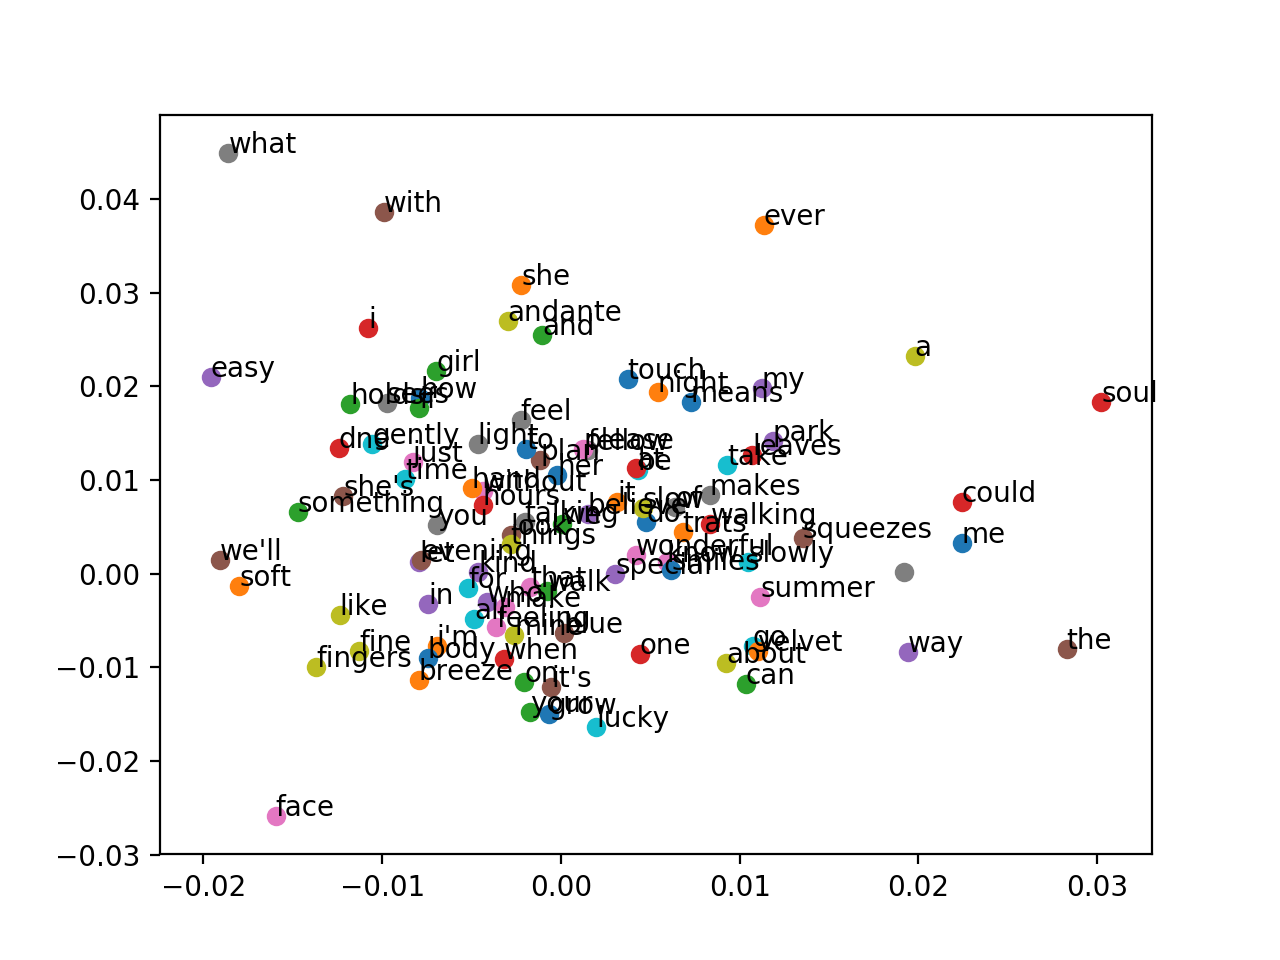

In [76]:
%matplotlib notebook
for i in range(W_h.shape[0]):
    plt.scatter(W_h[i,0],W_h[i,1])
    plt.annotate(id_to_word[i],[W_h[i,0],W_h[i,1]])